In [1]:
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go


from time import time
import numpy as np
import matplotlib.path as mpltPath

import math

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

In [2]:
folder="/home/shankar/All_thesis/Thesis_program/Data/shawnee/location_2/GMM"

In [3]:
location_in_time=pd.read_csv(folder+"/location_in_time.csv")

In [4]:
location_in_time

,Unnamed: 0,Start,End,passID,lat_min,lat_max,long_min,long_max
0,0,2023-01-16T17:34:19.000Z,2023-01-16T17:34:48.000Z,125,35.671009,35.671484,-96.662335,-96.662326
1,1,2023-01-16T17:35:24.000Z,2023-01-16T17:35:53.000Z,126,35.671015,35.671497,-96.662334,-96.662326
2,2,2023-01-16T17:36:52.000Z,2023-01-16T17:37:16.000Z,127,35.671011,35.671399,-96.662355,-96.662348
3,3,2023-01-16T17:38:04.000Z,2023-01-16T17:38:28.000Z,128,35.671016,35.671406,-96.662355,-96.662347
4,4,2023-01-16T17:39:08.000Z,2023-01-16T17:39:38.000Z,129,35.671005,35.671495,-96.662349,-96.662337


In [5]:
passes=location_in_time["passID"].values
passes

array([125, 126, 127, 128, 129])

In [6]:
each_data=[pd.read_csv(folder+f"/cluster_predicted_pass_{x}.csv") for x in location_in_time["passID"]]

In [7]:
# Compute heading
def compute_heading(df):
    df["heading"] = 0
    for i in range(len(df) - 1):
        a = df.loc[i, "latitude"] - df.loc[i + 1, "latitude"]
        b = df.loc[i, "longitude"] - df.loc[i + 1, "longitude"]
        d = 180 / np.pi * np.arctan2(a, b) + 180
        df.loc[i, "heading"] = d

In [8]:
def projectRollerWidth(df_in, rollerWidth=6, nPoints=6):
    df=df_in.copy(deep=True)
    copyDF = df.copy()
    halfWidth = rollerWidth // 2
    for i in np.arange(-halfWidth, halfWidth, rollerWidth / nPoints):
        tmpDF = copyDF.copy()
        tmpDF.latitude = (
            np.sin(2 * np.pi / 360 * (copyDF.heading.values - 90)) * i / 3600 / 101
            + copyDF.latitude.values
        )
        tmpDF.longitude = (
            np.cos(2 * np.pi / 360 * (copyDF.heading.values - 90)) * i / 3600 / 80
            + copyDF.longitude.values
        )
        tmpDF.original = False
        df = df.append(tmpDF)
    df =df.sort_values("timestamp")
    return df

In [9]:
each_data_projected=[[]]*len(each_data)
for i in range(len(passes)):
    each_data[i]["pass_no"]=i
    length=len(each_data[i])
    latitudes = np.linspace(location_in_time["lat_min"][i],location_in_time["lat_max"][i] , num=length)
    print(len(latitudes))
    each_data[i]["latitude"]=latitudes
    longitudes= np.linspace(location_in_time["long_min"][i],location_in_time["long_max"][i] , num=length)
    each_data[i]["longitude"]=longitudes
    
    each_data[i]["prev"]=each_data[i]["cluster"].shift(1)
    each_data[i]["change"]=each_data[i].apply(lambda x: 1 if abs(x["prev"]-x["cluster"]>1)  else 0, axis=1)
       
    print(i)
    if i==0:
        each_data[i]["first"]=True
        each_data[i]["last"]=False
    elif i==len(passes)-1:
        each_data[i]["first"]=False
        each_data[i]["last"]=True
    else:
        each_data[i]["first"]=False
        each_data[i]["last"]=False
        
        
    compute_heading(each_data[i])
    each_data_projected[i]=projectRollerWidth(each_data[i])

        
full_data=pd.concat(each_data)
full_data=full_data[full_data["pass_no"]!=0]

full_data_projected=pd.concat(each_data_projected)
full_data_projected=full_data_projected[full_data_projected["pass_no"]!=0]

226
0
226
1
186
2
187
3
234
4


In [10]:
full_data["time"]=full_data["timestamp"]
full_data["passID"]=full_data["pass_no"]
full_data["speed"]=1.1
full_data["temperature"]=167.5

full_data["density"]=full_data["cluster"]
full_data.to_csv(folder+"/full_data_to_project.csv")
full_data

,Unnamed: 0.1,Unnamed: 0,timestamp,total_power,p0,p1,p2,p3,p4,p5,...,prev,change,first,last,heading,time,passID,speed,temperature,density
0,0,0,2023-01-16 17:35:24.120000+00:00,100.000000,-2.000000,0.375842,2.000000,1.754883,2.000000,2.000000,...,NaN,0,False,False,89.049120,2023-01-16 17:35:24.120000+00:00,1,1.1,167.5,3
1,1,1,2023-01-16 17:35:24.257000+00:00,11.596138,-2.000000,-0.544107,0.913710,-0.976264,0.382378,-1.481994,...,3.0,1,False,False,89.049120,2023-01-16 17:35:24.257000+00:00,1,1.1,167.5,0
2,2,2,2023-01-16 17:35:24.384000+00:00,51.212139,-2.000000,-0.308310,-0.629798,-0.233850,-0.269963,0.157760,...,0.0,0,False,False,89.049120,2023-01-16 17:35:24.384000+00:00,1,1.1,167.5,0
3,3,3,2023-01-16 17:35:24.511000+00:00,39.000186,-0.789316,-1.122698,-0.707708,-0.530996,0.078025,-0.829679,...,0.0,0,False,False,89.049120,2023-01-16 17:35:24.511000+00:00,1,1.1,167.5,0
4,4,4,2023-01-16 17:35:24.638000+00:00,22.034464,0.044584,-1.195729,-0.092707,-1.023929,-0.694603,-0.983712,...,0.0,0,False,False,89.049120,2023-01-16 17:35:24.638000+00:00,1,1.1,167.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,229,229,2023-01-16 17:39:37.213000+00:00,60.061274,1.487480,1.297874,-0.532700,-0.784099,0.910506,0.960998,...,2.0,0,False,True,88.597119,2023-01-16 17:39:37.213000+00:00,4,1.1,167.5,3
230,230,230,2023-01-16 17:39:37.330000+00:00,61.202191,1.107628,1.397561,0.641673,0.030087,1.336552,0.105396,...,3.0,0,False,True,88.597119,2023-01-16 17:39:37.330000+00:00,4,1.1,167.5,3
231,231,231,2023-01-16 17:39:37.467000+00:00,72.841157,0.863628,0.611317,2.000000,0.536560,0.864613,1.203702,...,3.0,0,False,True,88.597118,2023-01-16 17:39:37.467000+00:00,4,1.1,167.5,3
232,232,232,2023-01-16 17:39:37.594000+00:00,47.461301,1.050667,-0.007594,1.268494,-0.579839,-0.020636,1.502925,...,3.0,0,False,True,88.597119,2023-01-16 17:39:37.594000+00:00,4,1.1,167.5,4


In [11]:
full_data_projected["time"]=full_data_projected["timestamp"]
full_data_projected["passID"]=full_data_projected["pass_no"]

full_data_projected["speed"]=1.1
full_data_projected["temperature"]=167.5

full_data_projected["density"]=full_data_projected["cluster"]
full_data_projected

# full_data_projected.to_csv(folder+"full_data_projected.csv")

,Unnamed: 0.1,Unnamed: 0,timestamp,total_power,p0,p1,p2,p3,p4,p5,...,prev,change,first,last,heading,time,passID,speed,temperature,density
0,0,0,2023-01-16 17:35:24.120000+00:00,100.000000,-2.00000,0.375842,2.000000,1.754883,2.00000,2.000000,...,NaN,0,False,False,89.04912,2023-01-16 17:35:24.120000+00:00,1,1.1,167.5,3
0,0,0,2023-01-16 17:35:24.120000+00:00,100.000000,-2.00000,0.375842,2.000000,1.754883,2.00000,2.000000,...,NaN,0,False,False,89.04912,2023-01-16 17:35:24.120000+00:00,1,1.1,167.5,3
0,0,0,2023-01-16 17:35:24.120000+00:00,100.000000,-2.00000,0.375842,2.000000,1.754883,2.00000,2.000000,...,NaN,0,False,False,89.04912,2023-01-16 17:35:24.120000+00:00,1,1.1,167.5,3
0,0,0,2023-01-16 17:35:24.120000+00:00,100.000000,-2.00000,0.375842,2.000000,1.754883,2.00000,2.000000,...,NaN,0,False,False,89.04912,2023-01-16 17:35:24.120000+00:00,1,1.1,167.5,3
0,0,0,2023-01-16 17:35:24.120000+00:00,100.000000,-2.00000,0.375842,2.000000,1.754883,2.00000,2.000000,...,NaN,0,False,False,89.04912,2023-01-16 17:35:24.120000+00:00,1,1.1,167.5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,233,233,2023-01-16 17:39:37.721000+00:00,40.243643,1.34466,-0.291694,1.744152,-0.348850,0.03541,0.568369,...,4.0,0,False,True,0.00000,2023-01-16 17:39:37.721000+00:00,4,1.1,167.5,4
233,233,233,2023-01-16 17:39:37.721000+00:00,40.243643,1.34466,-0.291694,1.744152,-0.348850,0.03541,0.568369,...,4.0,0,False,True,0.00000,2023-01-16 17:39:37.721000+00:00,4,1.1,167.5,4
233,233,233,2023-01-16 17:39:37.721000+00:00,40.243643,1.34466,-0.291694,1.744152,-0.348850,0.03541,0.568369,...,4.0,0,False,True,0.00000,2023-01-16 17:39:37.721000+00:00,4,1.1,167.5,4
233,233,233,2023-01-16 17:39:37.721000+00:00,40.243643,1.34466,-0.291694,1.744152,-0.348850,0.03541,0.568369,...,4.0,0,False,True,0.00000,2023-01-16 17:39:37.721000+00:00,4,1.1,167.5,4


In [12]:
lon_min = full_data_projected.longitude.min()
lon_max = full_data_projected.longitude.max()
lat_min = full_data_projected.longitude.min()
lat_max = full_data_projected.longitude.max()

nHexBins_lat = int(
    (lat_max - lat_min) * 3600 * 80 / 2
)  
nHexBins_lon = int(
    (lon_max - lon_min) * 3600 * 80 / 2
    
)  

nHexBins=max(nHexBins_lon,nHexBins_lat)
nHexBins

6

In [13]:
def getLastValue(hexBin):
#     print (hexBin)
    return hexBin[-1]


coverageFig = {}
# Coverage map colored by pass count
coverageFig["passes"] = ff.create_hexbin_mapbox(
    data_frame=full_data_projected,
    lat="latitude",
    lon="longitude",
    labels={"color": "Number of Passes"},
    nx_hexagon=nHexBins,
    agg_func=getLastValue,
    show_original_data=True,
    color="density",
    zoom=18,
)

coverageFig

{'passes': Figure({
     'data': [{'coloraxis': 'coloraxis',
               'customdata': array([[1.0, '-1.6870765392571545,0.6671927646014197', 0],
                                    [0.0, '-1.6870765392571545,0.667192997991572', 0],
                                    [4.0, '-1.6870765392571545,0.667193231381724', 0],
                                    ...,
                                    [0.0, '-1.687075798143885,0.6672029170730376', 0],
                                    [3.0, '-1.687075798143885,0.6672031504631897', 0],
                                    [3.0, '-1.687075798143885,0.6672033838533419', 0]], dtype=object),
               'geojson': {'features': [{'geometry': {'coordinates': [[[-
                                                                      96.66236541497
                                                                      19, 35.6709961
                                                                      4906195], [-
                                

In [14]:
len(coverageFig["passes"].data[0].geojson["features"]), len(coverageFig["passes"].data[0].customdata)

(618, 515)

In [15]:
vertices_list_c=[coverageFig["passes"].data[0].geojson["features"][i]["geometry"]['coordinates'][0] 
                 for i in range (len(coverageFig["passes"].data[0].geojson["features"]))]
vertices_collection={coverageFig["passes"].data[0].geojson["features"][i]["id"]:
                      coverageFig["passes"].data[0].geojson["features"][i]["geometry"]['coordinates'][0]
                     for i in range (len(coverageFig["passes"].data[0].geojson["features"]))}

len(vertices_collection)

618

In [16]:
def get_data_inside(dataframe,vertices):
#     print(vertices_k_v)
    vertex_path=mpltPath.Path(vertices)
    ret_data = vertex_path.contains_points(np.array(dataframe[["longitude","latitude"]]))
    if not dataframe[ret_data].empty:
#         print(dataframe[ret_data])
        return dataframe[ret_data]
    
get_data={vertex_point: get_data_inside(full_data_projected,vertices_collection[vertex_point])
          for vertex_point in vertices_collection}

In [17]:
def get_pass_and_density(df):
    try:
        return df.groupby(["passID","density"]).size() 
    except:
        return None

final_data={vertex_point: get_pass_and_density(get_data[vertex_point]) for vertex_point in get_data}

In [18]:
list(final_data.values())[68]

passID  density
2       1          1
        3          4
3       0          7
4       4          2
dtype: int64

In [19]:
with_val=([x for x in get_data.values() if x is not None])
# with_val[789]

In [20]:
# with_val[789].drop_duplicates(subset = "time")

In [21]:
def get_avg_density_per_pass(df):
    try:
        return df.drop_duplicates(subset = "time").groupby(["passID"])["density"].mean() 
    except:
        return None

pass_dens_avg={vertex_point: get_avg_density_per_pass(get_data[vertex_point]) for vertex_point in get_data}
pass_dens_with_avg_val=([x for x in pass_dens_avg.values() if x is not None])
new_z_avg=[[list(pass_dens_with_avg_val[i]),list(pass_dens_with_avg_val[i].index)] for i in range(len(pass_dens_with_avg_val))]
new_z_avg

[[[2.0], [2]],
 [[0.6666666666666666, 0.25], [2, 3]],
 [[2.3333333333333335, 1.3333333333333333], [2, 3]],
 [[1.0, 1.3333333333333333], [2, 3]],
 [[1.5, 1.3333333333333333], [2, 3]],
 [[2.0, 1.3333333333333333], [2, 3]],
 [[0.0, 0.0], [2, 3]],
 [[3.3333333333333335, 2.3333333333333335], [2, 3]],
 [[2.0, 0.6666666666666666], [2, 3]],
 [[0.0, 0.6666666666666666], [2, 3]],
 [[1.0, 0.0], [2, 3]],
 [[1.0, 1.5], [2, 3]],
 [[1.3333333333333333, 0.0], [2, 3]],
 [[2.3333333333333335, 2.5], [2, 3]],
 [[0.5, 2.0], [2, 3]],
 [[1.0, 1.0], [2, 3]],
 [[1.5, 0.0], [2, 3]],
 [[1.0, 0.0], [2, 3]],
 [[2.0], [2]],
 [[3.0], [2]],
 [[2.0, 2.5], [2, 4]],
 [[0.6666666666666666, 0.0, 3.0], [2, 3, 4]],
 [[2.3333333333333335, 1.3333333333333333, 1.3333333333333333], [2, 3, 4]],
 [[1.25, 1.3333333333333333, 1.0], [2, 3, 4]],
 [[1.5, 1.3333333333333333, 2.0], [2, 3, 4]],
 [[2.0, 1.3333333333333333, 2.5], [2, 3, 4]],
 [[0.0, 0.0, 2.25], [2, 3, 4]],
 [[3.3333333333333335, 2.3333333333333335, 1.0], [2, 3, 4]],
 [[2.0

In [22]:
# pass_dens_with_avg_val[789]

In [23]:
def get_max_density_per_pass(df):
    try:
        return df.drop_duplicates(subset = "time").groupby(["passID"])["density"].max()
    except:
        return None

pass_dens_max={vertex_point: get_max_density_per_pass(get_data[vertex_point]) for vertex_point in get_data}
pass_dens_with_max_val=([x for x in pass_dens_max.values() if x is not None])
new_z_max=[[list(pass_dens_with_max_val[i]),list(pass_dens_with_max_val[i].index)] for i in range(len(pass_dens_with_max_val))]
new_z_max

[[[3], [2]],
 [[1, 1], [2, 3]],
 [[3, 4], [2, 3]],
 [[3, 2], [2, 3]],
 [[4, 4], [2, 3]],
 [[3, 4], [2, 3]],
 [[0, 0], [2, 3]],
 [[4, 4], [2, 3]],
 [[3, 2], [2, 3]],
 [[0, 2], [2, 3]],
 [[2, 0], [2, 3]],
 [[2, 3], [2, 3]],
 [[4, 0], [2, 3]],
 [[3, 4], [2, 3]],
 [[1, 4], [2, 3]],
 [[2, 2], [2, 3]],
 [[2, 0], [2, 3]],
 [[1, 0], [2, 3]],
 [[2], [2]],
 [[3], [2]],
 [[3, 3], [2, 4]],
 [[1, 0, 4], [2, 3, 4]],
 [[3, 4, 4], [2, 3, 4]],
 [[3, 2, 3], [2, 3, 4]],
 [[4, 4, 3], [2, 3, 4]],
 [[3, 4, 4], [2, 3, 4]],
 [[0, 0, 3], [2, 3, 4]],
 [[4, 4, 3], [2, 3, 4]],
 [[3, 2, 4], [2, 3, 4]],
 [[0, 2, 4], [2, 3, 4]],
 [[2, 0, 1], [2, 3, 4]],
 [[2, 3, 4], [2, 3, 4]],
 [[4, 0, 4], [2, 3, 4]],
 [[3, 4, 4], [2, 3, 4]],
 [[1, 4, 4], [2, 3, 4]],
 [[2, 2, 4], [2, 3, 4]],
 [[3, 0, 1], [2, 3, 4]],
 [[4, 2, 2], [2, 3, 4]],
 [[4, 0, 1], [2, 3, 4]],
 [[3, 0, 4], [2, 3, 4]],
 [[4, 2, 4], [2, 3, 4]],
 [[4, 0], [2, 3]],
 [[3, 1], [2, 3]],
 [[4, 3], [2, 3]],
 [[4, 0], [2, 3]],
 [[3, 3], [2, 3]],
 [[4, 2], [2, 3]],
 [[3,

In [24]:
# # coverageFig["passes"].data[0].geojson["features"][i]["geometry"]['coordinates'][0]
# coverageFig

In [25]:
coverageFig["passes"].data[0].z=new_z_avg
coverageFig

{'passes': Figure({
     'data': [{'coloraxis': 'coloraxis',
               'customdata': array([[1.0, '-1.6870765392571545,0.6671927646014197', 0],
                                    [0.0, '-1.6870765392571545,0.667192997991572', 0],
                                    [4.0, '-1.6870765392571545,0.667193231381724', 0],
                                    ...,
                                    [0.0, '-1.687075798143885,0.6672029170730376', 0],
                                    [3.0, '-1.687075798143885,0.6672031504631897', 0],
                                    [3.0, '-1.687075798143885,0.6672033838533419', 0]], dtype=object),
               'geojson': {'features': [{'geometry': {'coordinates': [[[-
                                                                      96.66236541497
                                                                      19, 35.6709961
                                                                      4906195], [-
                                

In [26]:
len(new_z_max), new_z_max

(515,
 [[[3], [2]],
  [[1, 1], [2, 3]],
  [[3, 4], [2, 3]],
  [[3, 2], [2, 3]],
  [[4, 4], [2, 3]],
  [[3, 4], [2, 3]],
  [[0, 0], [2, 3]],
  [[4, 4], [2, 3]],
  [[3, 2], [2, 3]],
  [[0, 2], [2, 3]],
  [[2, 0], [2, 3]],
  [[2, 3], [2, 3]],
  [[4, 0], [2, 3]],
  [[3, 4], [2, 3]],
  [[1, 4], [2, 3]],
  [[2, 2], [2, 3]],
  [[2, 0], [2, 3]],
  [[1, 0], [2, 3]],
  [[2], [2]],
  [[3], [2]],
  [[3, 3], [2, 4]],
  [[1, 0, 4], [2, 3, 4]],
  [[3, 4, 4], [2, 3, 4]],
  [[3, 2, 3], [2, 3, 4]],
  [[4, 4, 3], [2, 3, 4]],
  [[3, 4, 4], [2, 3, 4]],
  [[0, 0, 3], [2, 3, 4]],
  [[4, 4, 3], [2, 3, 4]],
  [[3, 2, 4], [2, 3, 4]],
  [[0, 2, 4], [2, 3, 4]],
  [[2, 0, 1], [2, 3, 4]],
  [[2, 3, 4], [2, 3, 4]],
  [[4, 0, 4], [2, 3, 4]],
  [[3, 4, 4], [2, 3, 4]],
  [[1, 4, 4], [2, 3, 4]],
  [[2, 2, 4], [2, 3, 4]],
  [[3, 0, 1], [2, 3, 4]],
  [[4, 2, 2], [2, 3, 4]],
  [[4, 0, 1], [2, 3, 4]],
  [[3, 0, 4], [2, 3, 4]],
  [[4, 2, 4], [2, 3, 4]],
  [[4, 0], [2, 3]],
  [[3, 1], [2, 3]],
  [[4, 3], [2, 3]],
  [[4, 0], [

In [27]:
singles=[x for x in np.array(new_z_max).T[0] if len(x)==1]
len(singles),len(singles)/ len(new_z_max)

(185, 0.3592233009708738)

In [28]:
doubles=[x for x in np.array(new_z_max).T[0] if len(x)==2]
len(doubles),len(doubles)/ len(new_z_max)

(160, 0.3106796116504854)

In [29]:
triples=[x for x in np.array(new_z_max).T[0] if len(x)==3]
len(triples),len(triples)/ len(new_z_max)

(128, 0.24854368932038834)

In [30]:
quads=[x for x in np.array(new_z_max) if len(x[0])==4]
len(quads),len(quads)/ len(new_z_max)

(42, 0.08155339805825243)

In [31]:
# [x[1][3] for x in np.array(new_z_max) if len(x[0])==4]

In [32]:
def print_list_histgram(data_list, number_of_bins): 

    bins = np.linspace(math.ceil(min(data_list)), 
                       math.floor(max(data_list)),
                       number_of_bins) # fixed number of bins

    plt.xlim([min(data_list)-1, max(data_list)+1])
    plt.hist(data_list, bins=bins, alpha=0.5)
#     plt.title('Random Gaussian data (fixed number of bins)')
#     plt.xlabel('variable X (20 evenly spaced bins)')
#     plt.ylabel('count')

    plt.show()

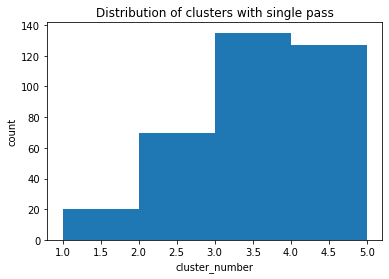

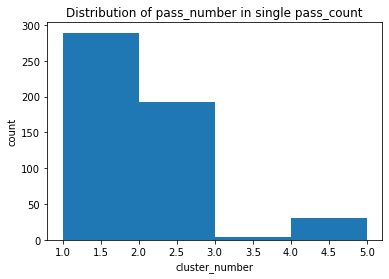

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [45]:
count_1s=[x[0] for x in np.array(new_z_max).T[0] if len(x)>=1]
bins = np.arange(1, 6, 1)
plt.hist(count_1s, bins=bins)
plt.title('Distribution of clusters with single pass')
plt.xlabel('cluster_number')
plt.ylabel('count')
plt.show()

count_1s_passes=[x[1][0] for x in np.array(new_z_max)]
bins = np.arange(1, 6, 1)
plt.hist(count_1s_passes, bins=bins)
plt.title('Distribution of pass_number in single pass_count')
plt.xlabel('cluster_number')
plt.ylabel('count')
plt.show()


count_1s_passes

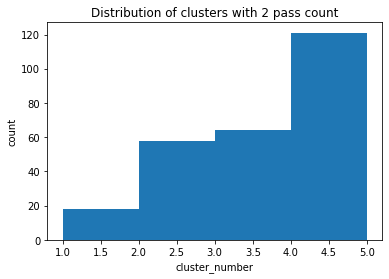

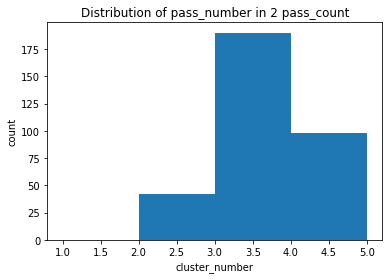

(dict_keys([1, 4, 2, 0, 3]),
 dict_values([18, 121, 58, 69, 64]),
 [0.03495145631067961,
  0.23495145631067962,
  0.11262135922330097,
  0.13398058252427184,
  0.12427184466019417])

In [34]:
count_2s=[x[1] for x in np.array(new_z_max).T[0] if len(x)>=2]
bins = np.arange(1, 6, 1)
plt.hist(count_2s, bins=bins)
plt.title('Distribution of clusters with 2 pass count')
plt.xlabel('cluster_number')
plt.ylabel('count')
plt.show()

count_2s_passes=[x[1][1] for x in np.array(new_z_max) if len(x[0])>=2]
bins = np.arange(1, 6, 1)
plt.hist(count_2s_passes, bins=bins)
plt.title('Distribution of pass_number in 2 pass_count')
plt.xlabel('cluster_number')
plt.ylabel('count')
plt.show()

Counter(count_2s).keys() , Counter(count_2s).values(),[x/len(new_z_max) for x in list(Counter(count_2s).values())]

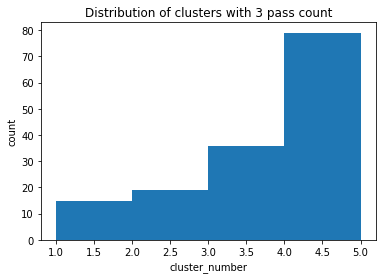

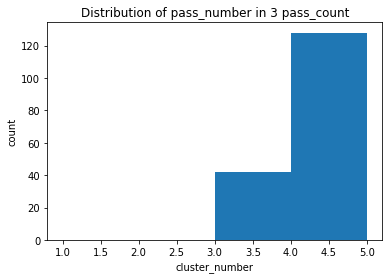

In [35]:
count_3s=[x[2] for x in np.array(new_z_max).T[0] if len(x)>=3]
bins = np.arange(1, 6, 1)
plt.hist(count_3s, bins=bins)
plt.title('Distribution of clusters with 3 pass count')
plt.xlabel('cluster_number')
plt.ylabel('count')
plt.show()

count_3s_passes=[x[1][2] for x in np.array(new_z_max) if len(x[0])>=3]
bins = np.arange(1, 6, 1)
plt.hist(count_3s_passes, bins=bins)
plt.title('Distribution of pass_number in 3 pass_count')
plt.xlabel('cluster_number')
plt.ylabel('count')
plt.show()

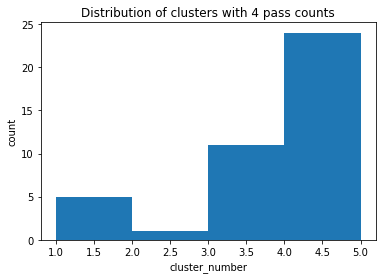

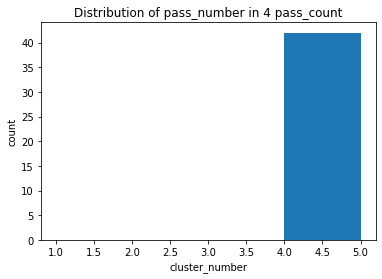

In [36]:
count_4s=[x[3] for x in np.array(new_z_max).T[0] if len(x)>=4]
bins = np.arange(1, 6, 1)
plt.hist(count_4s, bins=bins)
plt.title('Distribution of clusters with 4 pass counts')
plt.xlabel('cluster_number')
plt.ylabel('count')
plt.show()

count_4s_passes=[x[1][3] for x in np.array(new_z_max) if len(x[0])>=4]
bins = np.arange(1, 6, 1)
plt.hist(count_4s_passes, bins=bins)
plt.title('Distribution of pass_number in 4 pass_count')
plt.xlabel('cluster_number')
plt.ylabel('count')
plt.show()

In [37]:
####Average

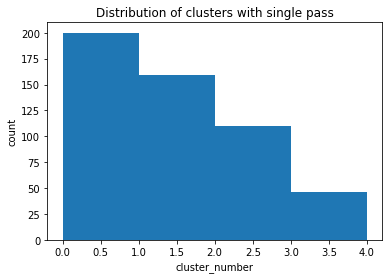

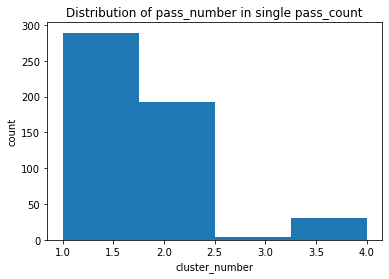

In [38]:
count_1s=[x[0] for x in np.array(new_z_avg).T[0] if len(x)>=1]
plt.hist(count_1s, 4)
plt.title('Distribution of clusters with single pass')
plt.xlabel('cluster_number')
plt.ylabel('count')
plt.show()

count_1s_passes=[x[1][0] for x in np.array(new_z_avg)]
plt.hist(count_1s_passes, 4)
plt.title('Distribution of pass_number in single pass_count')
plt.xlabel('cluster_number')
plt.ylabel('count')
plt.show()

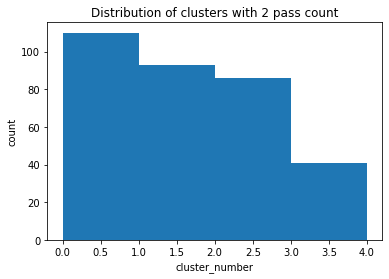

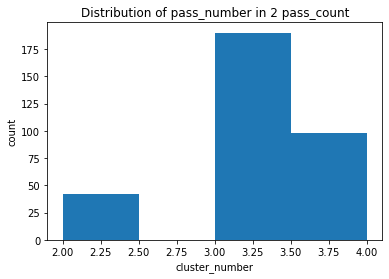

In [39]:
count_2s=[x[1] for x in np.array(new_z_avg).T[0] if len(x)>=2]
plt.hist(count_2s, 4)
plt.title('Distribution of clusters with 2 pass count')
plt.xlabel('cluster_number')
plt.ylabel('count')
plt.show()

count_2s_passes=[x[1][1] for x in np.array(new_z_avg) if len(x[0])>=2]
plt.hist(count_2s_passes, 4)
plt.title('Distribution of pass_number in 2 pass_count')
plt.xlabel('cluster_number')
plt.ylabel('count')
plt.show()

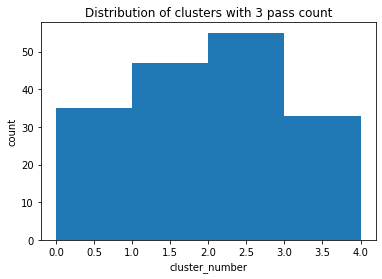

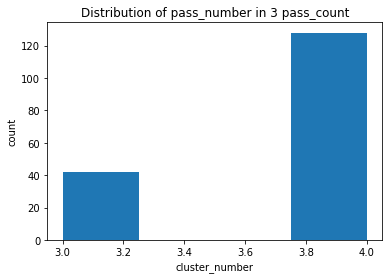

In [40]:
count_3s=[x[2] for x in np.array(new_z_avg).T[0] if len(x)>=3]
plt.hist(count_3s, 4)
plt.title('Distribution of clusters with 3 pass count')
plt.xlabel('cluster_number')
plt.ylabel('count')
plt.show()

count_3s_passes=[x[1][2] for x in np.array(new_z_avg) if len(x[0])>=3]
plt.hist(count_3s_passes, 4)
plt.title('Distribution of pass_number in 3 pass_count')
plt.xlabel('cluster_number')
plt.ylabel('count')
plt.show()

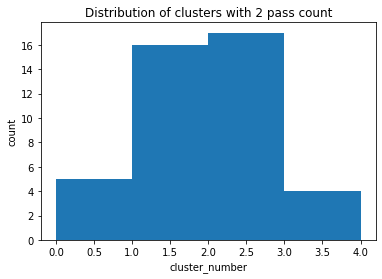

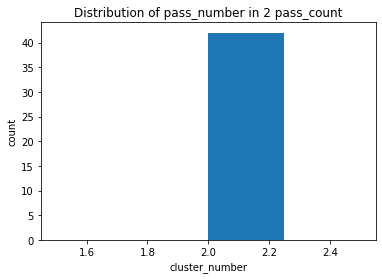

In [41]:
count_2s=[x[1] for x in np.array(new_z_avg).T[0] if len(x)>=4]
plt.hist(count_2s, 4)
plt.title('Distribution of clusters with 2 pass count')
plt.xlabel('cluster_number')
plt.ylabel('count')
plt.show()

count_2s_passes=[x[1][1] for x in np.array(new_z_avg) if len(x[0])>=4]
plt.hist(count_2s_passes, 4)
plt.title('Distribution of pass_number in 2 pass_count')
plt.xlabel('cluster_number')
plt.ylabel('count')
plt.show()

In [42]:
# import pickle
# # save the model to disk
# filename = 'pass_count_save.pkl'
# pickle.dump(new_z, open(filename, 'wb'))

In [43]:
# # load the model from disk
# loaded_z = pickle.load(open(filename, 'rb'))
# # print(loaded_z)
# print(loaded_z==new_z)